In [1]:
using OrdinaryDiffEq
using Plots
using DataDrivenDiffEq, DataDrivenSparse

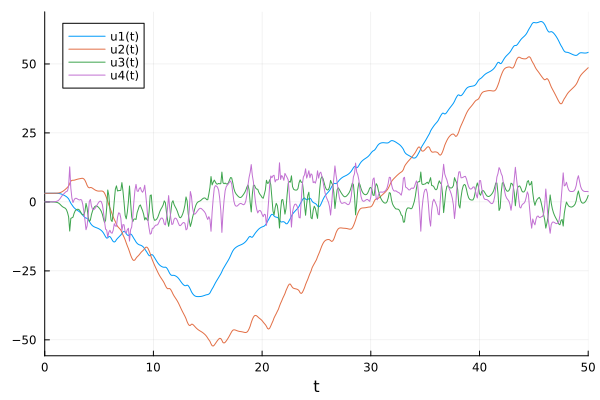

In [2]:
m1 = 1 #units of kg
m2 = 1 
l1 = 1 #units of m
l2 = 1
g = 10 #units of kg*m/s^2

p = [m1, m2, l1, l2, g]

function pendulum(x,p,t)
    m1, m2, l1, l2, g = p
    dθ_1 = x[3]
    dθ_2 = x[4]
    dω_1 = begin 
        numerator = -g*(2m1 + m2)*sin(x[1]) - m2*g*sin(x[1] - 2x[2]) - 2sin(x[1] - x[2])*m2*(x[4]^2*l2 + x[3]^2*l1*cos(x[1] - x[2]))
        denominator = l1*(2m1 + m2 - m2*cos(2(x[1] - x[2])))
        numerator / denominator
        end     	
    dω_2 = begin 
        numerator = 2sin(x[1]-x[2])*(x[3]^2*l1*(m1 + m2) + g*(m1 + m2)*cos(x[1]) + x[4]^2*l2*m2*cos(x[1] - x[2]))
        denominator = l2*(2m1 + m2 - m2*cos(2(x[1] - x[2])))
        numerator / denominator
        end   

    return [dθ_1, dθ_2, dω_1, dω_2]
end

x0 = [3.141f0, 3.141f0, 0, 0] 

t_transient = 0f0
N_t = 500
dt = 0.1f0

tspan = (0f0, Float32(t_transient + N_t * dt))
prob = ODEProblem(pendulum, x0, tspan, p) 
sol = solve(prob, Tsit5(), saveat=t_transient:dt:t_transient + N_t * dt)

display(plot(sol))

In [5]:
@variables t, θ_1(t), θ_2(t), ω_1(t), ω_2(t)
ddprob = DataDrivenProblem(sol)
u = [θ_1, θ_2, ω_1, ω_2]
#basis = Basis([polynomial_basis(u, 3); sin_basis(u,8); cos_basis(u,8)], u, iv = t)
basis = Basis([polynomial_basis(u, 3); sin_basis(u,1); cos_basis(u,1)], u, iv = t)
optimiser = STLSQ(Float32.(exp10.(-5:0.1:-1)))
ddsol = solve(ddprob, basis, optimiser, options = DataDrivenCommonOptions(digits = 1))

"DataDrivenSolution{Float32}"

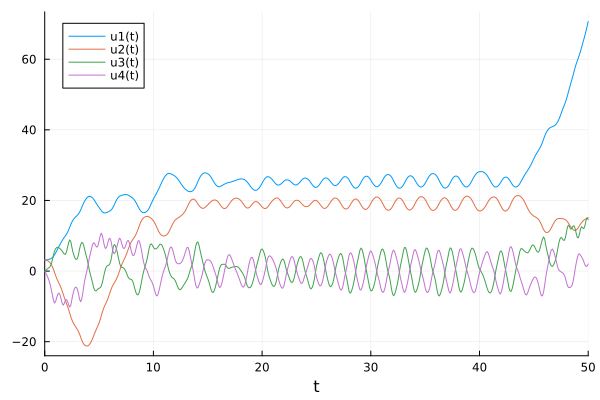

In [6]:
function sindy_fct(u,p,t)
    ddsol(u,p,t)
end

sindy_prob = ODEProblem(sindy_fct, x0, tspan, ddsol.prob.p)
sol_sindy = solve(sindy_prob, Tsit5(), saveat=saveat=t_transient:dt:t_transient + N_t * dt)
display(plot(sol_sindy))

In [7]:
using NODEData, Flux, SciMLSensitivity, Statistics

In [9]:
abstract type AbstractNDEModel end 

"""
NODE{P,R,A,K} <: AbstractNDEModel

Model for setting up and training Neural Ordinary Differential Equations.

# Fields:

* `p` vector of trainable parameters 
* `prob` ODEProblem 
* `alg` Algorithm to use for the `solve` command 
* `kwargs` any additional keyword arguments that should be handed over
"""

struct NODE{P,R,A,K} <: AbstractNDEModel
    p::P 
    prob::R 
    alg::A
    kwargs::K
end 

function NODE(prob; alg=Tsit5(), kwargs...)
    p = prob.p 
    NODE{typeof(p), typeof(prob), typeof(alg), typeof(kwargs)}(p, prob, alg, kwargs)
end 

Flux.@functor NODE
Flux.trainable(m::NODE) = (p=m.p,)

function (m::NODE)(X,p=m.p)
    (t, x) = X 
    Array(solve(remake(m.prob; tspan=(t[1],t[end]),u0=x[:,1],p=p), m.alg; saveat=t, m.kwargs...))
end

#Create training data
t_train = t_transient:dt:t_transient+N_t*dt
sol_arr = Array(sol(t_train))

train_data = NODEDataloader(Float32.(sol_arr), t_train, 3)

p, re_nn = Flux.destructure(Chain(Dense(4,16,relu), Dense(16,16,relu), Dense(16,4)))

#node(u, p, t) = re_nn(p)(u)
#node(u, p, t) = ddsol(u,ddsol.prob.p) + re_nn(p)(u)
#node(u, p, t) = sindy(u,sindy.sol.prob.p,t) + re_nn(p)(u)
node(u, p, t) = re_nn(p)(ddsol(u,ddsol.prob.p))
node_prob = ODEProblem(node, x0, (Float32(0.),Float32(dt)), p)

model = NODE(node_prob)

NODE{Vector{Float32}, ODEProblem{false,Vector{Float32},Tuple{Float32, Float32},…}, Tsit5{Static.False,…}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}(Float32[0.37628883, 0.0637538, 0.07692496, 0.038589444, -0.040677074, 0.011320738, -0.08183491, 0.09380473, 0.2523409, 0.23580053  …  -0.423394, -0.39108077, -0.29755437, -0.24226427, 0.1267626, 0.26009968, 0.0, 0.0, 0.0, 0.0], ODEProblem{false,Vector{Float32},Tuple{Float32, Float32},…}(ODEFunction{false,SciMLBase.AutoSpecialize,…}(node, LinearAlgebra.UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, SciMLBase.DEFAULT_OBSERVED, nothing, nothing), Float32[3.141, 3.141, 0.0, 0.0], (0.0f0, 0.1f0), Float32[0.37628883, 0.0637538, 0.07692496, 0.038589444, -0.040677074, 0.011320738, -0.08183491, 0.09380473, 0.2523409, 0.23580053  …  -0.423394, -0.39108077, -0.29755437, -0.24226427, 0.1267626, 0.26009968, 0.0, 0.0, 0.0, 0.0], Base.Pai

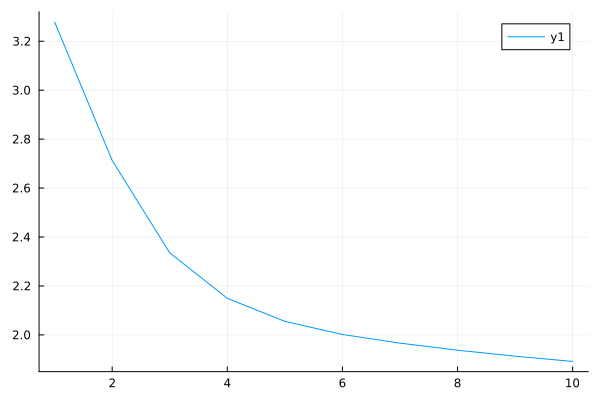

In [10]:
loss = Flux.Losses.mse
opt = Flux.AdamW(1f-3)
opt_state = Flux.setup(opt, model)
loss_log = Float32[]
for epoch in 1:10
    losses = Float32[]
    for (i, data) in enumerate(train_data)
        t, x = data
        val, grads = Flux.withgradient(model) do m
            result = m((t,x))
            loss(result, x)
        end
        # Save the loss from the forward pass. (Done outside of gradient.)
        push!(losses, val)

        # Detect loss of Inf or NaN. Print a warning, and then skip update!
        if !isfinite(val)
            @warn "loss is $val on item $i" epoch
            continue
        end

    Flux.update!(opt_state, model, grads[1])
    end
    epoch_loss = Statistics.mean(losses)
    push!(loss_log, epoch_loss)
    if (epoch % 1) == 0 
        print("Epoch: $epoch; Loss: $epoch_loss \r")
        flush(stdout)
    end

    if (epoch % 30) == 0  # reduce the learning rate every 30 epochs
        η /= 2
        Flux.adjust!(opt_state, η)
    end
end
plot(loss_log)

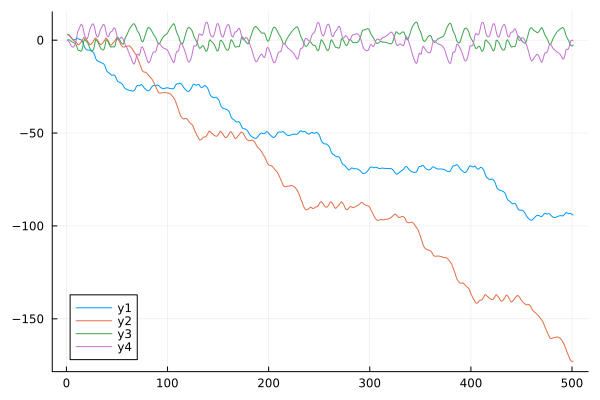

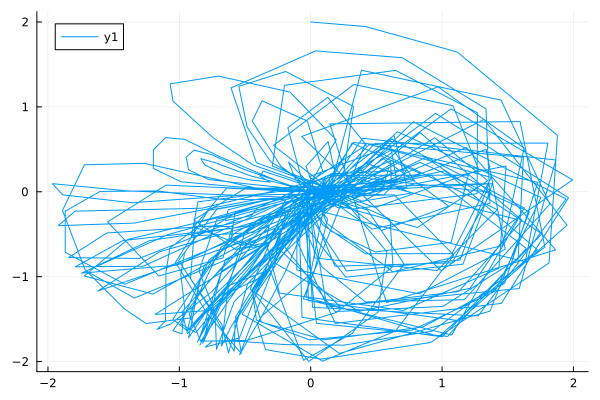

In [11]:
#Test model
times = convert(Array{Float32,1}, collect(0:0.1:50))
rec_sol = model((times,x0))
display(plot(transpose(Array(rec_sol))))
plot(sin.(rec_sol[1,:])*l1 + sin.(rec_sol[2,:])*l2, -cos.(rec_sol[1,:])*l1 - cos.(rec_sol[2,:])*l2)

[ Info: Saved animation to c:\Users\Simon\Documents\PIK\Code\ode_test.jl\images\pendulum.gif


Plots.AnimatedGif("c:\\Users\\Simon\\Documents\\PIK\\Code\\ode_test.jl\\images\\pendulum.gif")
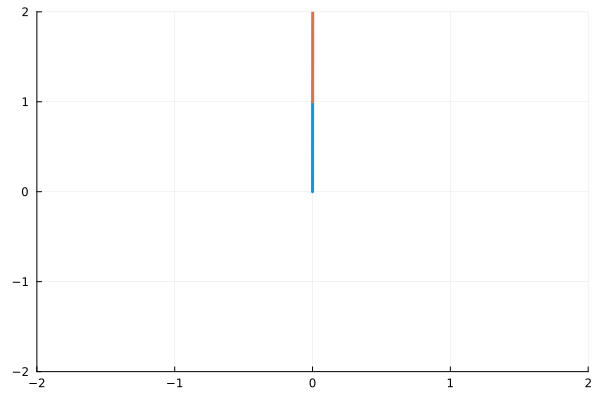

In [12]:
n = length(rec_sol[1,:])
alpha_decay_length = 20
alphas = [zeros(n - alpha_decay_length); collect(range(0,0.5,alpha_decay_length))]
anim = @animate for i in 1:n
    plot([0,sin.(rec_sol[1,i])*l1], [0,-cos.(rec_sol[1,i])*l1], lw=3, legend=false)
    plot!([sin.(rec_sol[1,i])*l1, sin.(rec_sol[1,i])*l1 + sin.(rec_sol[2,i])*l2], [-cos.(rec_sol[1,i])*l1, -cos.(rec_sol[1,i])*l1 - cos.(rec_sol[2,i])*l2], lw=3, legend=false)
    plot!(sin.(rec_sol[1,1:i])*l1 + sin.(rec_sol[2,1:i])*l2, -cos.(rec_sol[1,1:i])*l1 - cos.(rec_sol[2,1:i])*l2, lw=1, linealpha=alphas[end-i+1:1:end], legend=false)
    xlims!(-(l1+l2),(l1+l2))
    ylims!(-(l1+l2),(l1+l2))
end
gif(anim, "../images/pendulum.gif", fps = 10)